In [46]:
#Big Mart Sales Prediction

Sales Prediction for Big Mart Outlets
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.



Data Dictionary
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.



Train file: CSV containing the item outlet information with sales value
Test file: CSV containing item outlet combinations for which sales need to be forecasted

In [ ]:
#Evaluation Metric

Evaluation Metric
Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in sample submission.

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the Root Mean Square Error value to judge your response.

In [47]:
#1. Initial Setup and Data Loading

importing additional libraries for more sophisticated preprocessing and modeling
Making a copy of the original test data is crucial - it preserves the original identifiers for the final submission
Combining train and test datasets for preprocessing is a best practice because:

It ensures consistent preprocessing across both datasets
It allows us to use all available data for encoding categorical variables
It prevents data leakage while maintaining consistent transformations

In [45]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Load train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [73]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [74]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [76]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [77]:
train_df.shape

(8523, 12)

In [78]:
train_df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [79]:
train_df.size

102276

In [80]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [81]:
test_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.664849,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,8.645000,0.027047,94.412000,1987.000000
50%,12.500000,0.054154,141.415400,1999.000000
75%,16.700000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


In [82]:
test_df.shape

(5681, 11)

In [83]:
test_df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,976
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,1606
Outlet_Location_Type,0


In [84]:
test_df.size

62491

In [4]:
# Make a copy of the original test dataframe for final submission
test_df_original = test_df.copy()

In [5]:
# Combine train and test for preprocessing (without the target variable)
target = 'Item_Outlet_Sales'
train_id = train_df.shape[0]
combined = pd.concat([train_df.drop(target, axis=1), test_df], axis=0, ignore_index=True)

In [48]:
#2. Feature Engineering

Inconsistent category labels create unnecessary dimensionality in one-hot encoding
Standardizing category names improves model interpretation and reduces noise
This specific issue stems from having multiple representations of the same concept

In [44]:
# 1. Fix typos in Item_Fat_Content
combined['Item_Fat_Content'] = combined['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

In [49]:
#Creating Higher-Level Categories

This implements feature abstraction - grouping granular categories into higher-level ones
Benefits:

Reduces cardinality (fewer categories to encode)
Captures business-relevant distinctions (perishable vs non-perishable goods behave differently)
Adds domain knowledge to the model
Creates more robust features with more examples per category

In [8]:
# 2. Create a new feature for Item_Type_Combined (grouping similar categories)
combined['Item_Type_Combined'] = combined['Item_Type'].map({
    'Fruits and Vegetables': 'Perishable',
    'Snack Foods': 'Non-Perishable',
    'Household': 'Non-Perishable',
    'Frozen Foods': 'Perishable',
    'Dairy': 'Perishable',
    'Baking Goods': 'Non-Perishable',
    'Canned': 'Non-Perishable',
    'Health and Hygiene': 'Non-Perishable',
    'Meat': 'Perishable',
    'Breads': 'Perishable',
    'Hard Drinks': 'Non-Perishable',
    'Soft Drinks': 'Non-Perishable',
    'Starchy Foods': 'Non-Perishable',
    'Breakfast': 'Non-Perishable',
    'Seafood': 'Perishable',
    'Others': 'Non-Perishable'
})

In [50]:
#Transforming Year to Age

Converting absolute years to relative ages makes the feature more meaningful
Benefits:

Makes the model more generalizable across time periods
Creates a more intuitive relationship with the target (age affects sales more directly than year)
Prevents the model from learning spurious correlations based on specific years

In [11]:
# 3. Extract establishment year and calculate outlet age
current_year = 2013  # as mentioned in the problem statement
# Use 'Outlet_Age' instead of 'Outlet_Establishment_Year' as the column has been renamed
combined['Outlet_Age'] = current_year - combined['Outlet_Age']
# No need for rename as it has already been done before
#combined.rename(columns={'Outlet_Establishment_Year': 'Outlet_Age'}, inplace=True)

In [51]:
#Handling Zero Visibility Values

Zero visibility values are likely recording errors (items must have some visibility)
Imputing with the mean by item type:

Preserves the relationship between item type and visibility
Is more accurate than global mean imputation
Addresses the issue without removing data points

In [12]:
# 4. Fix Item_Visibility zeros with mean visibility of that item type
visibility_avg = combined.groupby('Item_Type')['Item_Visibility'].mean()
for item_type in visibility_avg.index:
    zero_indices = (combined['Item_Type'] == item_type) & (combined['Item_Visibility'] == 0)
    combined.loc[zero_indices, 'Item_Visibility'] = visibility_avg[item_type]

In [52]:
#Binning Continuous Variables

Binning continuous variables has several benefits:

Captures non-linear relationships with the target
Reduces the impact of outliers
Can reveal patterns that aren't visible in the raw continuous data


We use two different binning approaches:

pd.cut(): Fixed-width bins for MRP (price bands are interpretable)
pd.qcut(): Quantile-based bins for visibility (ensures equal distribution across categories)

In [13]:
# 5. Create Item_MRP_Bin feature
combined['Item_MRP_Bin'] = pd.cut(combined['Item_MRP'],
                                 bins=[0, 50, 100, 150, 200, 250, np.inf],
                                 labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250+'])

In [53]:
#Creating Interaction Features

Interaction features capture relationships between variables that affect the target jointly
These specific interactions model real-world retail dynamics:

MRP × Outlet_Age: Older outlets might sell higher-priced items differently than newer ones
MRP × Item_Weight: Price-to-weight ratio captures value density, a key retail metric

In [14]:
# 6. Create Item_Visibility_Bin feature
combined['Item_Visibility_Bin'] = pd.qcut(combined['Item_Visibility'],
                                          q=4,
                                          labels=['Low Visibility', 'Medium Visibility', 'High Visibility', 'Very High Visibility'])

In [54]:
#Strategic Missing Value Imputation

This implements hierarchical imputation strategy:

First try to impute based on relevant groupings (more accurate)
Fall back to global statistics if group-based imputation isn't possible


For weights: we use median by item type because similar items typically have similar weights
For outlet size: we use mode by outlet type because certain outlet types tend to have standard sizes

In [15]:
# 7. Create interaction features
combined['Item_MRP_X_Outlet_Age'] = combined['Item_MRP'] * combined['Outlet_Age']
combined['Item_MRP_X_Item_Weight'] = combined['Item_MRP'] * combined['Item_Weight']

In [16]:
# 8. Fill missing values strategically
# For Item_Weight, use median weight by Item_Type
item_weight_median = combined.groupby('Item_Type')['Item_Weight'].median()
for item_type in item_weight_median.index:
    null_indices = (combined['Item_Type'] == item_type) & (combined['Item_Weight'].isnull())
    combined.loc[null_indices, 'Item_Weight'] = item_weight_median[item_type]

In [55]:
#Log Transformation

Log transformation is applied to Item_Visibility because:

Visibility typically has a right-skewed distribution
Log transformation makes this distribution more normal
Many ML algorithms perform better with normally distributed features
It reduces the impact of outliers


We use log1p() (log(1+x)) instead of simple log() to handle zero or near-zero values safely

In [17]:
# 9. Log transform Item_Visibility to normalize it
combined['Item_Visibility'] = np.log1p(combined['Item_Visibility'])

In [70]:
#Distribution of Target Variable (Item_Outlet_Sales)

A histogram is a graphical representation of the distribution of a dataset. It shows the frequency of data points falling within specific ranges (bins) along the x-axis. The y-axis represents the count or frequency of data points in each bin.

Purpose:

Understanding the Shape: The shape of the histogram tells us about the underlying distribution of the data. For example, a bell-shaped curve indicates a normal distribution, while a skewed distribution might have a longer tail on one side.
Identifying Outliers: Extreme values or outliers can be identified by looking for isolated bars or gaps in the histogram.
Checking for Skewness: Skewness is a measure of the asymmetry of the distribution. A histogram with a longer tail on the right side is right-skewed (positive skew), while a longer tail on the left side is left-skewed (negative skew).

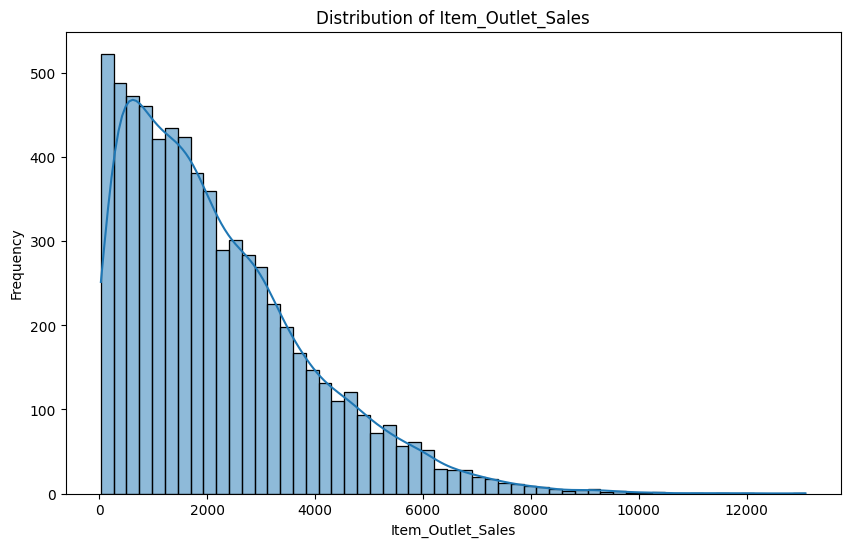

In [63]:
#  Distribution of Target Variable (Item_Outlet_Sales)
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True)
plt.title('Distribution of Item_Outlet_Sales')
plt.xlabel('Item_Outlet_Sales')
plt.ylabel('Frequency')
plt.show()

In [71]:
#Correlation Matrix of Numerical Features

A correlation matrix is a table showing the correlation coefficients between multiple variables. Each cell in the matrix represents the correlation between two variables. Correlation coefficients range from -1 to +1, where:

+1 indicates a perfect positive linear relationship (when one variable increases, the other also increases).
-1 indicates a perfect negative linear relationship (when one variable increases, the other decreases).
0 indicates no linear relationship.

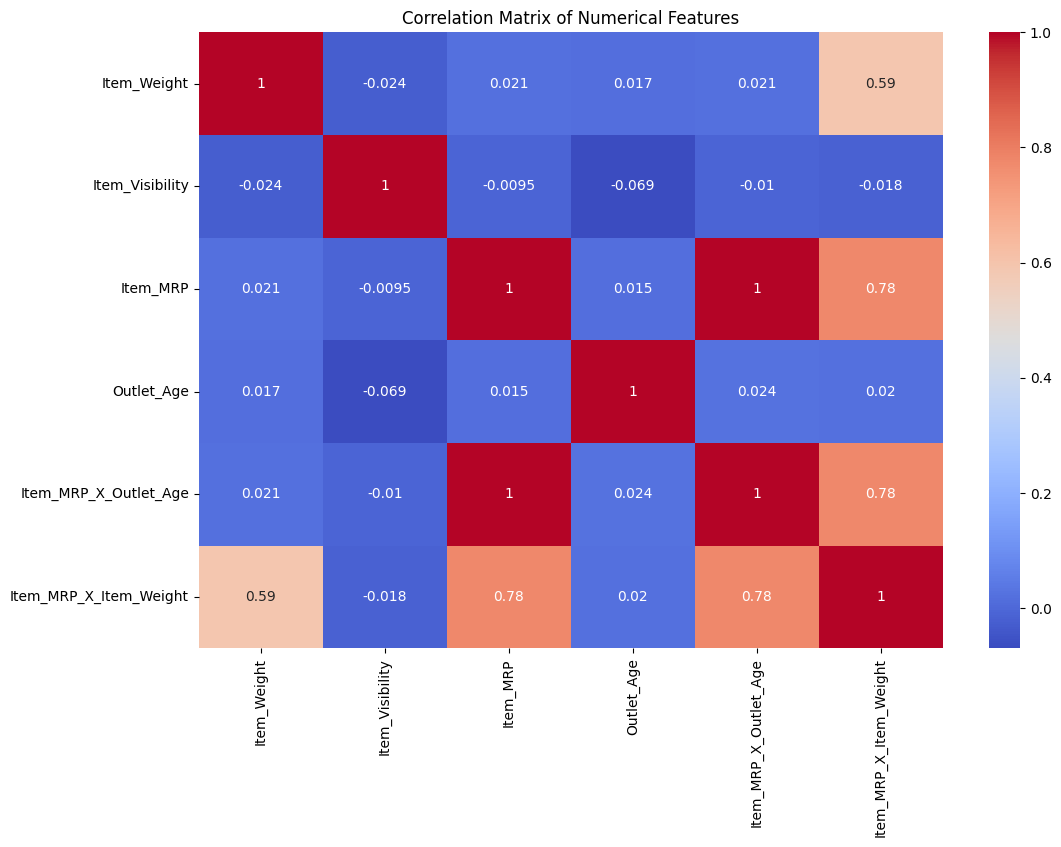

In [64]:
#Correlation Matrix of Numerical Features
plt.figure(figsize=(12, 8))
correlation_matrix = X_train[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [56]:
#Feature Selection and Encoding

Explicit listing of features ensures we only use what we need
Separating numerical and categorical features makes preprocessing more transparent
One-hot encoding with drop_first=True:

Converts categorical variables to a format ML algorithms can use
Dropping the first category prevents the "dummy variable trap" (perfect multicollinearity)
Reduces dimensionality while preserving all information

In [18]:
# Prepare for encoding and drop unnecessary features
categorical_features = ['Item_Fat_Content', 'Item_Type', 'Item_Type_Combined',
                       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
                       'Item_MRP_Bin', 'Item_Visibility_Bin']

numerical_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP',
                     'Outlet_Age', 'Item_MRP_X_Outlet_Age', 'Item_MRP_X_Item_Weight']

In [19]:
# One-hot encode categorical variables
combined_encoded = pd.get_dummies(combined, columns=categorical_features, drop_first=True)

In [57]:
#Data Splitting

After preprocessing the combined data, we need to split it back into train and test
The validation set (20% of training data) serves to:

Evaluate model performance during development
Enable early stopping to prevent overfitting
Provide unbiased error estimates before final testing


Setting random_state=42 ensures reproducibility

In [20]:
# Split back into train and test
X_train_encoded = combined_encoded.iloc[:train_id]
X_test_encoded = combined_encoded.iloc[train_id:]

In [21]:
# Get the target variable back
y_train = train_df[target]

In [22]:
# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_encoded, y_train,
                                                    test_size=0.2, random_state=42)

In [58]:
#Hyperparameter Tuning

We switched from GridSearchCV to RandomizedSearchCV because:

It's more efficient for large parameter spaces
It can find good solutions with fewer iterations
It allows exploring more parameters in a fixed computational budget


The expanded parameter space includes:

Core XGBoost parameters (n_estimators, max_depth, learning_rate)
Regularization parameters (reg_alpha, reg_lambda) to prevent overfitting
Sampling parameters (subsample, colsample_bytree) for model robustness
Tree construction parameters (min_child_weight, gamma) for better splits


We optimize for MAE since that's one of our primary metrics
5-fold cross-validation provides robust parameter evaluation

In [23]:
# Define more extensive hyperparameter grid for tuning
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10]
}

In [24]:
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [25]:
# Use RandomizedSearchCV for more efficient hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Try 50 different combinations
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1  # Use all available processors
)


In [27]:
# Before fitting the model, drop the 'Item_Identifier' and 'Outlet_Identifier' columns
X_train = X_train.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
X_valid = X_valid.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)

# Now, fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 200, 300, 500],
                                        'reg_alpha': [0, 0.1, 1, 10],
                                        'reg_lambda': [0, 0.1, 1, 10],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [28]:
# Get best parameters and model
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 10, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}


In [59]:
#Final Model Training

We create a new model with the best parameters found during tuning
Early stopping is implemented to prevent overfitting:

It monitors performance on the validation set
Stops training when performance stops improving for 50 consecutive rounds
Automatically selects the optimal number of trees


The validation set serves as an independent evaluation during training

In [29]:
# Train final model with best parameters
final_xgboost = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

In [32]:
# Instead of passing early_stopping_rounds to fit, we'll use a callback
from xgboost.callback import EarlyStopping
import xgboost as xgb

# Create an EarlyStopping callback
early_stop = EarlyStopping(rounds=50,  # Stop if no improvement for 50 rounds
                           save_best=True)  # Save the best model

# Create DMatrix for training and validation data
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Specify parameters for training
params = final_xgboost.get_params()  # Get parameters from your XGBRegressor object

# Train the model using xgb.train() with the callback
final_xgboost = xgb.train(params,
                         dtrain,
                         num_boost_round=params['n_estimators'],  # Use n_estimators from params
                         evals=[(dvalid, 'validation')],
                         early_stopping_rounds=50,  # Set early stopping rounds
                         verbose_eval=False,
                         callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:36:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [60]:
#Prediction and Evaluation

We evaluate on the validation set to get an unbiased estimate of model performance
Clipping predictions to non-negative values:

Enforces a business constraint (sales can't be negative)
Improves practical usability of the model
Can improve error metrics by removing impossible predictions


We calculate both MAE and RMSE because:

MAE is more interpretable (average error in sales units)
RMSE penalizes large errors more heavily (useful for business impact assessment)

In [62]:
# Predict on validation set
# Convert X_valid to DMatrix before prediction
dvalid = xgb.DMatrix(X_valid)  # Create DMatrix for X_valid
final_predictions = final_xgboost.predict(dvalid)  # Now predict using the DMatrix

In [35]:
# Clip predictions to non-negative values
final_predictions = np.clip(final_predictions, 0, None)


In [36]:
# Evaluate final model
final_mae = mean_absolute_error(y_valid, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_valid, final_predictions))

In [37]:
print(f'Final Model MAE: {final_mae}')
print(f'Final Model RMSE: {final_rmse}')

Final Model MAE: 718.7514054828829
Final Model RMSE: 1024.6331811677733


In [72]:
#Predicted vs. Actual Sales (Validation Set)

A scatter plot is used to visualize the relationship between two numerical variables. Each point on the plot represents a data point, with its x-coordinate representing the value of one variable and its y-coordinate representing the value of the other variable.

Purpose:

Model Performance Assessment: By plotting predicted values against actual values, you can visually assess the model's accuracy. Ideally, the points should lie close to a diagonal line (perfect predictions).
Identifying Patterns: You can look for patterns in the scatter plot, such as areas where the model tends to overpredict or underpredict.
Detecting Outliers: Outliers in the predictions can be identified by points that are far away from the diagonal line.

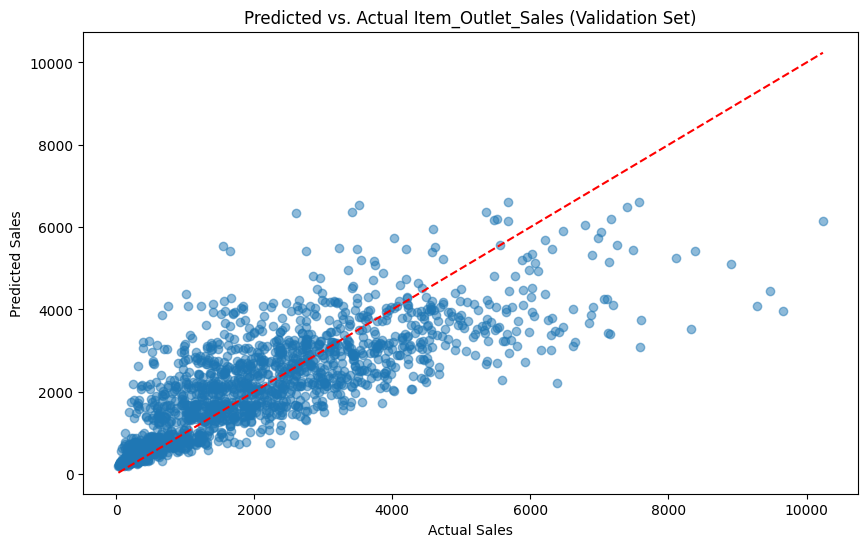

In [69]:
#Predicted vs. Actual Sales (Validation Set)
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, final_predictions, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Add a diagonal line
plt.title('Predicted vs. Actual Item_Outlet_Sales (Validation Set)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

In [40]:
# Predict on test set
# Convert X_test_encoded to DMatrix before prediction

# Drop the 'Item_Identifier' and 'Outlet_Identifier' columns from X_test_encoded
X_test_encoded = X_test_encoded.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)

dtest = xgb.DMatrix(X_test_encoded)  # Create DMatrix for X_test_encoded
test_preds = final_xgboost.predict(dtest)  # Now predict using the DMatrix
test_preds = np.clip(test_preds, 0, None)  # Ensure no negative predictions

In [41]:
# Prepare submission file with required columns
submission = pd.DataFrame({
    'Item_Identifier': test_df_original['Item_Identifier'],
    'Outlet_Identifier': test_df_original['Outlet_Identifier'],
    'Item_Outlet_Sales': test_preds
})


In [61]:
#Feature Importance Analysis

Visualizing feature importance provides several benefits:

Model interpretability - understanding what drives predictions
Feature selection insights for future iterations
Business intelligence about sales drivers
Validation that our engineered features are valuable


Saving the plot allows for documentation and sharing of insights

<Figure size 1200x800 with 0 Axes>

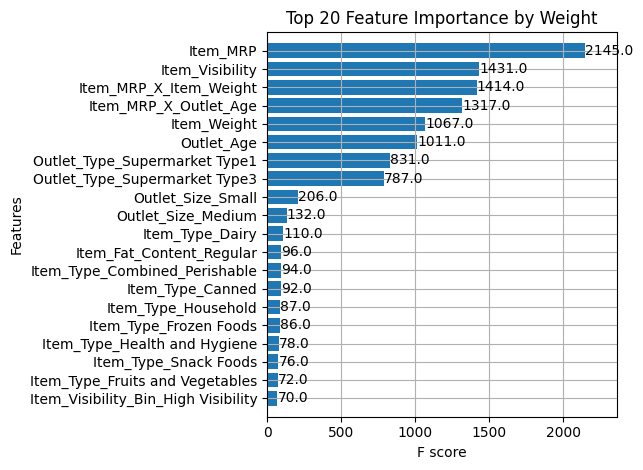

In [42]:
# Feature importance analysis
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_xgboost, max_num_features=20, height=0.8)
plt.title('Top 20 Feature Importance by Weight')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [43]:
# Save submission to CSV
submission.to_csv('improved_submission.csv', index=False)

print("✅ Improved submission file 'improved_submission.csv' saved successfully!")

✅ Improved submission file 'improved_submission.csv' saved successfully!
